# DengAI - Predicting Disease Spread using XGRegressor

This project is a challenge from [Driven Data](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/page/80/).

The current status: **Finished**

# Table of Contents
- [Overview](#overview)
- [Features description](#features_description)
- [Understanding the problem](#understanding_problem)
- [Feature engineering](#feature_engineering)
	- [Importing data](#fe_importing_data)
	- [Treating missing values](#fe_treating_missing)
	- [Treating date/season related features](#fe_treating_date)
	- [Lagging features](#fe_lagging_features)
	- [Feature selection](#fe_feature_selection)
- [Model evaluation](#model_evaluation)
- [Predicting the test dataset](#predicting_test)
- [Discussion](#discussion)

## Overview <a name="overview"></a>

### Can you predict local epidemics of dengue fever?

Dengue fever is a mosquito-borne disease that occurs in tropical and sub-tropical parts of the world. In mild cases, symptoms are similar to the flu: fever, rash, and muscle and joint pain. In severe cases, dengue fever can cause severe bleeding, low blood pressure, and even death.

Because mosquitoes carry it, the transmission dynamics of dengue are related to climate variables such as temperature and precipitation. Although the relationship to climate is complex, a growing number of scientists argue that climate change is likely to produce distributional shifts that will have significant public health implications worldwide.

Using environmental data collected by various U.S. Federal Government agencies—from the Centers for Disease Control and Prevention to the National Oceanic and Atmospheric Administration in the U.S. Department of Commerce— *can you predict the number of dengue fever cases reported each week in San Juan, Puerto Rico and Iquitos, Peru?*

### Goal

The project's goal is to predict the **total_cases** label for each (**city, year, weekofyear**) in the test set. There are two cities, San Juan and Iquitos, with test data for each city spanning 5 and 3 years respectively. You will make one submission that contains predictions for both cities. The data for each city were concatenated along with a city column indicating the source: **sj** for San Juan and **iq** for Iquitos. The test set is a real future hold-out, meaning the test data are sequential and non-overlapping with any of the training data. Throughout, missing values have were filled as *NaNs*.

## Features description

The description of every feature is following:
### City and date indicators
- **city** – City abbreviations: sj for San Juan and iq for Iquitos
- **week_start_date** – Date given in yyyy-mm-dd format

### NOAA's GHCN daily climate data weather station measurements
- **station_max_temp_c** – Maximum temperature
- **station_min_temp_c** – Minimum temperature
- **station_avg_temp_c** – Average temperature
- **station_precip_mm** – Total precipitation
- **station_diur_temp_rng_c** – Diurnal temperature range

### PERSIANN satellite precipitation measurements (0.25x0.25 degree scale)
- **precipitation_amt_mm** – Total precipitation

### NOAA's NCEP Climate Forecast System Reanalysis measurements (0.5x0.5 degree scale)
- **reanalysis_sat_precip_amt_mm** – Total precipitation
- **reanalysis_dew_point_temp_k** – Mean dew point temperature
- **reanalysis_air_temp_k** – Mean air temperature
- **reanalysis_relative_humidity_percent** – Mean relative humidity
- **reanalysis_specific_humidity_g_per_kg** – Mean specific humidity
- **reanalysis_precip_amt_kg_per_m2** – Total precipitation
- **reanalysis_max_air_temp_k** – Maximum air temperature
- **reanalysis_min_air_temp_k** – Minimum air temperature
- **reanalysis_avg_temp_k** – Average air temperature
- **reanalysis_tdtr_k** – Diurnal temperature range

### Satellite vegetation - Normalized difference vegetation index (NDVI) - NOAA's CDR Normalized Difference Vegetation Index (0.5x0.5 degree scale) measurements
- **ndvi_se** – Pixel southeast of city centroid
- **ndvi_sw** – Pixel southwest of city centroid
- **ndvi_ne** – Pixel northeast of city centroid
- **ndvi_nw** – Pixel northwest of city centroid

## Understanding the problem <a name="understanding_problem"></a>

Before any other step, it's essential to understand the disease and the given features, and then we can get insights from it.

### What is Dengue and how is it proliferated?

Dengue is a mosquito-transmitted disease. The mosquito Aedes aegypti, a primary vector of dengue, yellow fever, and chikungunya viruses, is widely distributed in the **subtropics and tropics** [[1]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3516267/). According to WHO (*World Health Organization*), **climate change may affect transmission**, as dengue mosquitoes reproduce more quickly and bite more frequently at **higher temperatures** [[2]](https://www.who.int/heli/risks/vectors/denguecontrol/en/). Also, in proximity to human settlements, Aedes aegypti mosquitoes breed primarily in **artificial water containers**, and the mosquito’s life-cycle is closely associated with **human activities**. Larval habitats are increasing rapidly in **urban areas**.

The temperature variations and **rainfall intensity** affect the reproductive cycle and survival of the vector, which causes changes in its distribution and density since mosquitoes need **humidity** and temperatures ranging between **15°C and 35°C** to survive and reproduce [[3]](http://www.scielo.br/pdf/ramb/v63n11/0104-4230-ramb-63-11-0957.pdf). Rainfall provides plenty of breeding sites for mosquito vectors such as puddles, while humidity affects the adult mosquitoes’ survival and **biting frequency** [[4]](https://bmcpublichealth.biomedcentral.com/articles/10.1186/s12889-018-5532-4). Finally, there is a **negative correlation** between the Diurnal Temperature Range (**DTR**) and dengue incident [[5]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5002035/).

The dengue symptoms start **4-7 days** after the mosquito bite [[6]](https://www.summitmedicalgroup.com/library/adult_health/aha_dengue_fever/).

### Features explained

The driven features in the dataset are **city**, **year**, **weekofyear**. Also, **week_start_date** can be helpful to understand trends and patterns in data.

Some explanatory variables are very intuitive. The precipitation features represent the amount (in mm) of water downfall on that current week (**station_precip_mm**, **precipitation_amt_mm**, **reanalysis_sat_precip_amt_mm**, **reanalysis_precip_amt_kg_per_m2**). The same precipitation information is given from different sources and different scales.

The temperature features represent the weekly climate conditions. This information is given in a tricky way. For example, **station_max_temp_c** is the weekly maximum temperature average, and **station_min_temp_c** weekly minimum average. But **station_avg_temp_c**, which is the average temperature, is not the mean between the weekly maximum average and minimum average, but the mean of the daily average from that week. The same goes for air temperature features (**reanalysis_air_temp_k**, **reanalysis_max_air_temp_k**, **reanalysis_min_air_temp_k**, **reanalysis_avg_temp_k**). It's important to notice that some temperature features are expressed in **Kelvin** and others in **Celsius**.

The humidity is measured in several ways in this dataset. There is a Dew Point temperature (**eanalysis_dew_point_temp_k**), relative humidity (**reanalysis_relative_humidity_percent**) and specific humidity (**reanalysis_specific_humidity_g_per_kg**). Some studies confirm that dew point and humidity have a nearly linear relationship [[7]](https://journals.ametsoc.org/doi/10.1175/BAMS-86-2-225). It is possible to measure the humidity percentage using the dew point and air temperature [[8]](http://www.reahvac.com/tools/humidity-formulas/).

Finally, the **NDVI** is a measure of how much green vegetation presents at a determined location. [[9]](https://gisgeography.com/ndvi-normalized-difference-vegetation-index/). This number ranges from -1 (none or less green) to +1 (very green).

We can note that a series of factors may cause dengue occurrence:
- High temperatures
- Rainfall intensity
- Humidity
- Urban areas and human proximity

Doing a quick recap on the features we have, we can group them related to the possible dengue spread causes.

|	     Temperature	  |	           Rain             |               Humidity              | Urbanization |
|-------------------------|-----------------------------|-------------------------------------|--------------|
|    station_max_temp_c   |   station_precip_mm         |    reanalysis_dew_point_temp_k      |   ndvi_se    |
|    station_min_temp_c   |   precipitation_amt_mm      |reanalysis_relative_humidity_percent |   ndvi_sw    |
|    station_avg_temp_c   |reanalysis_sat_precip_amt_mm |reanalysis_specific_humidity_g_per_kg|   ndvi_ne    |
| station_diur_temp_rng_c |reanalysis_precip_amt_kg_per_m2|        reanalysis_air_temp_k        |   ndvi_nw    |
|    reanalysis_tdtr_k    |             -               |      reanalysis_max_air_temp_k      |      -       |
|   reanalysis_avg_temp_k |             -               |      reanalysis_min_air_temp_k      |      -       |


Important to remember: the target variable is **'total_cases'**. We have to predict the number of cases in **two different cities**. In a given moment, we will separate the data into two dataframes and observing the behavior separately.

## Feature Engineering <a name="feature_engineering"></a>

### Importing data <a name="fe_importing_data"></a>

Let's begin the data manipulation based on what we learned so far.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

The data is separated into two datasets: features_train and labels.

In [2]:
#Loading Train dataset
df_features_train = pd.read_csv('data/dengue_features_train.csv')
df_labels_train = pd.read_csv('data/dengue_labels_train.csv')
#Loading Test dataset
df_features_test = pd.read_csv('data/dengue_features_test.csv')
df_labels_test = pd.read_csv('data/submission_format.csv')

In [3]:
df_features_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 24 columns):
city                                     1456 non-null object
year                                     1456 non-null int64
weekofyear                               1456 non-null int64
week_start_date                          1456 non-null object
ndvi_ne                                  1262 non-null float64
ndvi_nw                                  1404 non-null float64
ndvi_se                                  1434 non-null float64
ndvi_sw                                  1434 non-null float64
precipitation_amt_mm                     1443 non-null float64
reanalysis_air_temp_k                    1446 non-null float64
reanalysis_avg_temp_k                    1446 non-null float64
reanalysis_dew_point_temp_k              1446 non-null float64
reanalysis_max_air_temp_k                1446 non-null float64
reanalysis_min_air_temp_k                1446 non-null float64
reanalysis_precip

In [4]:
df_labels_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 4 columns):
city           1456 non-null object
year           1456 non-null int64
weekofyear     1456 non-null int64
total_cases    1456 non-null int64
dtypes: int64(3), object(1)
memory usage: 45.6+ KB


We can observe that the labels contain the **dependent variable**, our target, **total_cases**. To facilitate data manipulation, let's put all data into a single *dataframe*.

In [5]:
df_train = pd.merge(df_features_train, df_labels_train, how='left', left_on=['city','year','weekofyear'], right_on=['city','year','weekofyear']) 
df_test = pd.merge(df_features_test, df_labels_test, how='left', left_on=['city','year','weekofyear'], right_on=['city','year','weekofyear']) 


In [6]:
df_train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


### Treating missing values <a name="fe_treating_missing"></a>

The first thing to do with the data is to check missing values. We can use a missingno library to visualize the missing value relevance before treating data.

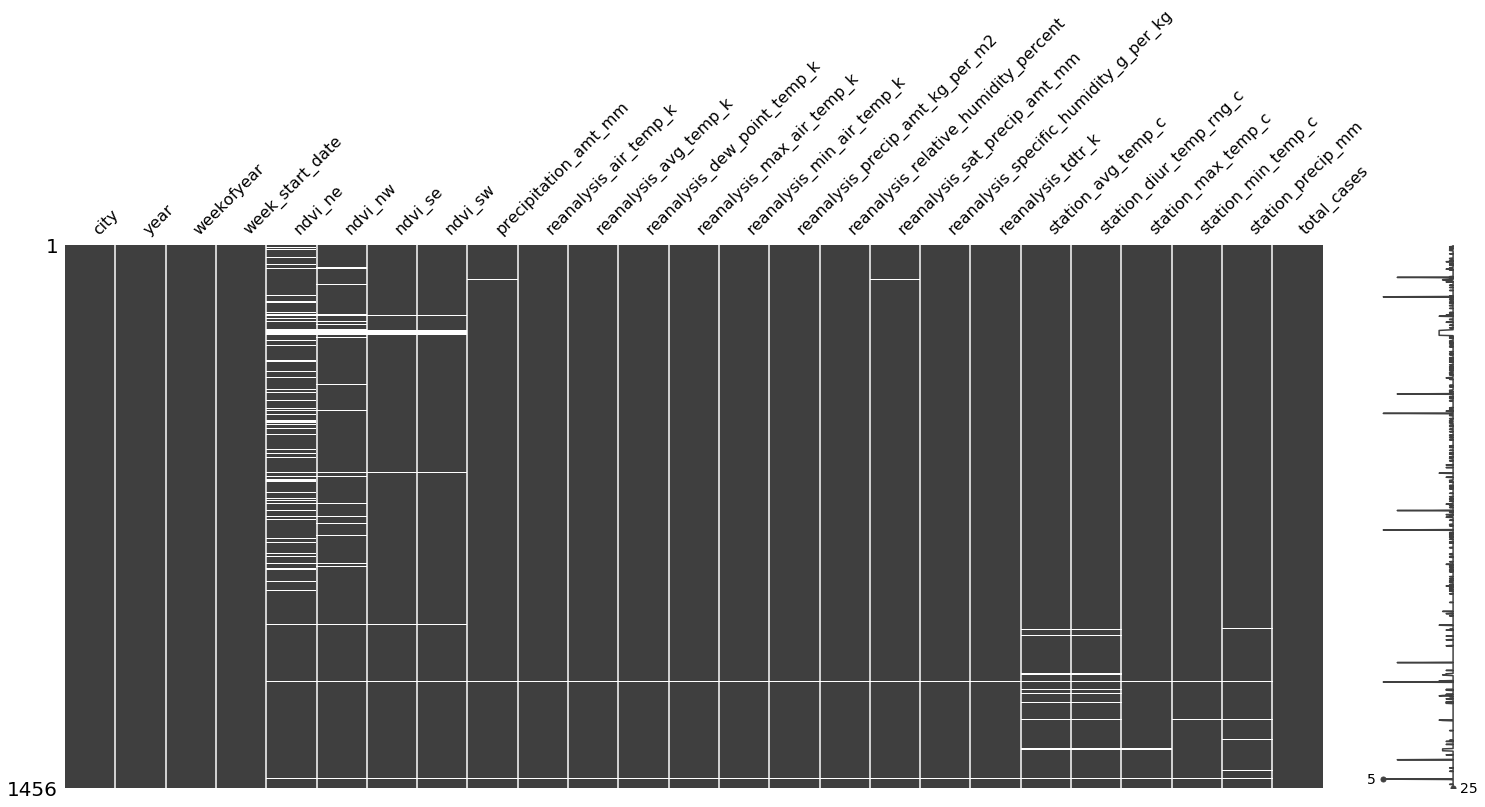

In [7]:
#Train dataset
msno.matrix(df_train);

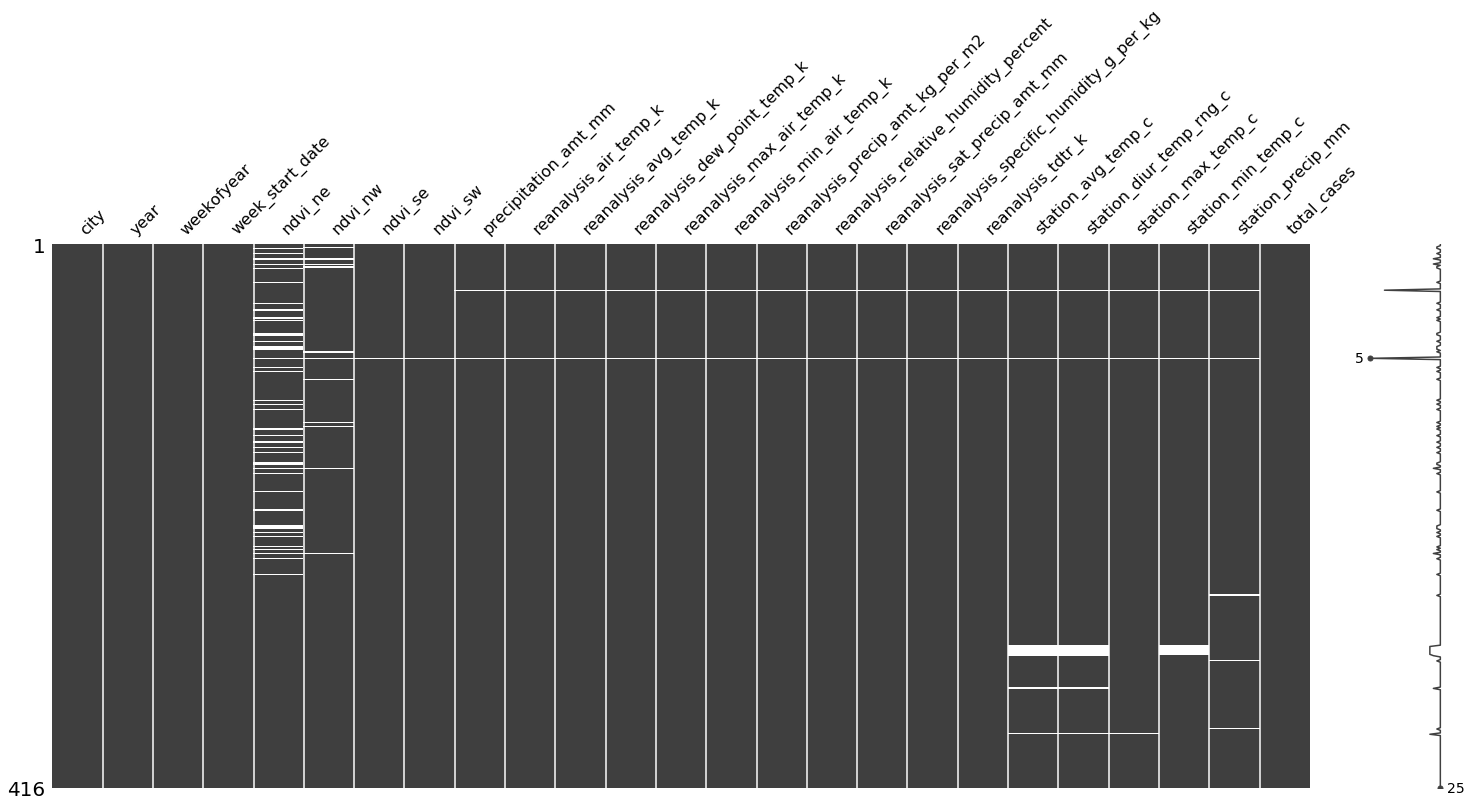

In [8]:
#Test dataset
msno.matrix(df_test);

It is apparent some missing values in this dataset, represented by the yellow color in the heatmap. Some data are *entirely missing*, except for the labels. Also is notable the missing values in the **NDVI** features, some **temperature** features from NOAA's GHCN source, and some in the **precipitation** features.

There are some ways to overcome this issue.

#### Precipitation features

This dataset contains three precipitation amount features representing similar the same information but from different sources. Let's see how similar those features are.

In [9]:
cols_precipitation = ['station_precip_mm', 'precipitation_amt_mm', 'reanalysis_sat_precip_amt_mm', 'reanalysis_precip_amt_kg_per_m2']

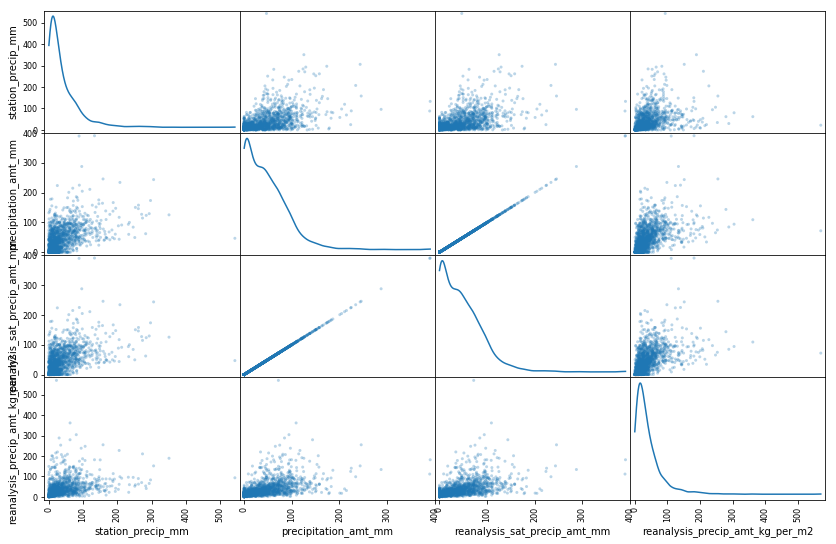

In [10]:
pd.plotting.scatter_matrix(df_train[cols_precipitation], alpha = 0.3, figsize = (14,9), diagonal = 'kde');

There is *multicollinearity* between the **precipitation_amt_mm**, **reanalysis_sat_precip_amt_mm** features. Actually, they have exactly the same data. So, let's *remove* one of them.

In [11]:
df_train.drop(['reanalysis_sat_precip_amt_mm'], axis=1, inplace=True)
df_test.drop(['reanalysis_sat_precip_amt_mm'], axis=1, inplace=True)

cols_precipitation = ['station_precip_mm', 'precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2']

Also, we can observe that the **station_precip_mm** and **reanalysis_precip_amt_kg_per_m2** features don't present a linear relation with the other elements. This situation is *plausible* since those features were generated with different techniques and from different sources.
> Precipitation measured in kg_per_m2 and mm are equivalent.

In [12]:
#Filtering missing values from precipitation_amt_mm, where exist value on station_precip_mm column
df_train[cols_precipitation][~df_train['station_precip_mm'].isnull() & (df_train['precipitation_amt_mm'].isnull())]


,station_precip_mm,precipitation_amt_mm,reanalysis_precip_amt_kg_per_m2
93,1.3,NaN,20.1
94,8.9,NaN,4.4
95,16.0,NaN,14.4


Observe that all missing values from **precipitation_amt_mm** are presented in the column **reanalysis_sat_precip_amt_mm**. So, it is safe to *remove any* of those two features. The **reanalysis_sat_precip_amt_mm** will be removed later, in the appropriate moment.

Notice that some missing values from those two features are presented on **station_precip_mm**. It is possible to fulfill those missing values just copying from the **station_precip_mm** or **reanalysis_precip_amt_kg_per_m2** features. The inverse is also possible. It is also possible to use the mean between the other features to fulfill those values.

In [13]:
cols_precipitation = ['station_precip_mm', 'precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2']

In [14]:
#Showing the number of missing values from station_precip_mm that contains value on precipitation_amt_mm or reanalysis_precip_amt_kg_per_m2
df_train[cols_precipitation][(~df_train['precipitation_amt_mm'].isnull() | ~df_train['reanalysis_precip_amt_kg_per_m2'].isnull()) & df_train['station_precip_mm'].isnull()].shape                            


(12, 3)

In [15]:
#Checking one of the NaN features
df_train[cols_precipitation].iloc[[94]]

,station_precip_mm,precipitation_amt_mm,reanalysis_precip_amt_kg_per_m2
94,8.9,NaN,4.4


In [16]:
def fill_nan_average(row, cols):
    return row[cols].mean()

In [17]:
#fill NaN values of precipitation_amt_mm
df_train['precipitation_amt_mm'] = df_train.apply(lambda row: 
                                               fill_nan_average(row, ['station_precip_mm', 'reanalysis_precip_amt_kg_per_m2']) 
                                               if np.isnan(row['precipitation_amt_mm']) & (~np.isnan(row['station_precip_mm']) | ~np.isnan(row['reanalysis_precip_amt_kg_per_m2']))
                                               else row['precipitation_amt_mm'], axis=1)
df_test['precipitation_amt_mm'] = df_test.apply(lambda row: 
                                               fill_nan_average(row, ['station_precip_mm', 'reanalysis_precip_amt_kg_per_m2']) 
                                               if np.isnan(row['precipitation_amt_mm']) & (~np.isnan(row['station_precip_mm']) | ~np.isnan(row['reanalysis_precip_amt_kg_per_m2']))
                                               else row['precipitation_amt_mm'], axis=1)



In [18]:
#Checking one of the NaN again, to see the change
df_train[cols_precipitation].iloc[[94]]

,station_precip_mm,precipitation_amt_mm,reanalysis_precip_amt_kg_per_m2
94,8.9,6.65,4.4


In [19]:
#Let's fill the others precipitation features
df_train['station_precip_mm'] = df_train.apply(lambda row: 
                                               fill_nan_average(row, ['precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2']) 
                                               if np.isnan(row['station_precip_mm']) & (~np.isnan(row['precipitation_amt_mm']) | ~np.isnan(row['reanalysis_precip_amt_kg_per_m2']))
                                               else row['station_precip_mm'], axis=1)
df_train['reanalysis_precip_amt_kg_per_m2'] = df_train.apply(lambda row: 
                                               fill_nan_average(row, ['station_precip_mm', 'precipitation_amt_mm']) 
                                               if np.isnan(row['reanalysis_precip_amt_kg_per_m2']) & (~np.isnan(row['station_precip_mm']) | ~np.isnan(row['precipitation_amt_mm']))
                                               else row['reanalysis_precip_amt_kg_per_m2'], axis=1)
df_test['station_precip_mm'] = df_test.apply(lambda row: 
                                               fill_nan_average(row, ['precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2']) 
                                               if np.isnan(row['station_precip_mm']) & (~np.isnan(row['precipitation_amt_mm']) | ~np.isnan(row['reanalysis_precip_amt_kg_per_m2']))
                                               else row['station_precip_mm'], axis=1)
df_test['reanalysis_precip_amt_kg_per_m2'] = df_test.apply(lambda row: 
                                               fill_nan_average(row, ['station_precip_mm', 'precipitation_amt_mm']) 
                                               if np.isnan(row['reanalysis_precip_amt_kg_per_m2']) & (~np.isnan(row['station_precip_mm']) | ~np.isnan(row['precipitation_amt_mm']))
                                               else row['reanalysis_precip_amt_kg_per_m2'], axis=1)


#### NDVI features

The NDVI features represent the vegetation around the city corners. Instead of using those features separated, we can derivate them, conserving the relevance and reducing dimensionality. For example, we can remove the four corners features and substitute for a *mean* value.

In [20]:
cols_ndvi = ['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw']

In [21]:
def ndvi_mean(row):
    return row[cols_ndvi].mean()

In [22]:
#Creating new features
df_train['ndvi_mean'] = df_train.apply(lambda row: ndvi_mean(row), axis=1)
df_test['ndvi_mean'] = df_test.apply(lambda row: ndvi_mean(row), axis=1)

In [23]:
#Removing the old NDVI features
df_train.drop(cols_ndvi, axis=1, inplace=True)
df_test.drop(cols_ndvi, axis=1, inplace=True)

In [24]:
cols_ndvi = ['ndvi_mean']

#### Temperature features

Before check any temperature feature, even the ones regard humidity; it is notable that some features present *Kelvin* unit. Normalizing to a single measure is necessary. I will foster *Celsius* as the standard unit.
> The only exception is the **reanalysis_tdtr_k** feature since diurnal temperature is independent of the unit.

In [25]:
def convertKelvinToCelsius(k):
    return k - 273.15

In [26]:
cols_kelvin = ['reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_air_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k']


In [27]:
#Creating new Celsius features
df_train['reanalysis_avg_temp_c'] = df_train.apply(lambda row: convertKelvinToCelsius(row['reanalysis_avg_temp_k']), axis=1)
df_train['reanalysis_dew_point_temp_c'] = df_train.apply(lambda row: convertKelvinToCelsius(row['reanalysis_dew_point_temp_k']), axis=1)
df_train['reanalysis_air_temp_c'] = df_train.apply(lambda row: convertKelvinToCelsius(row['reanalysis_air_temp_k']), axis=1)
df_train['reanalysis_max_air_temp_c'] = df_train.apply(lambda row: convertKelvinToCelsius(row['reanalysis_max_air_temp_k']), axis=1)
df_train['reanalysis_min_air_temp_c'] = df_train.apply(lambda row: convertKelvinToCelsius(row['reanalysis_min_air_temp_k']), axis=1)

df_test['reanalysis_avg_temp_c'] = df_test.apply(lambda row: convertKelvinToCelsius(row['reanalysis_avg_temp_k']), axis=1)
df_test['reanalysis_dew_point_temp_c'] = df_test.apply(lambda row: convertKelvinToCelsius(row['reanalysis_dew_point_temp_k']), axis=1)
df_test['reanalysis_air_temp_c'] = df_test.apply(lambda row: convertKelvinToCelsius(row['reanalysis_air_temp_k']), axis=1)
df_test['reanalysis_max_air_temp_c'] = df_test.apply(lambda row: convertKelvinToCelsius(row['reanalysis_max_air_temp_k']), axis=1)
df_test['reanalysis_min_air_temp_c'] = df_test.apply(lambda row: convertKelvinToCelsius(row['reanalysis_min_air_temp_k']), axis=1)


In [28]:
#Removing Kelvin features
df_train.drop(cols_kelvin, axis=1, inplace=True)
df_test.drop(cols_kelvin, axis=1, inplace=True)

In [29]:
cols_temperature = ['station_max_temp_c', 'station_min_temp_c', 'station_avg_temp_c', 'station_diur_temp_rng_c', 'reanalysis_tdtr_k', 'reanalysis_avg_temp_c']


Let's check the missing values of the temperature features again. Then, we review the correlation.

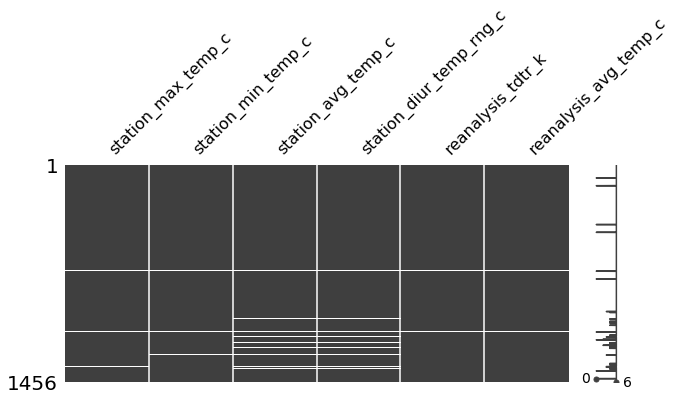

In [30]:
msno.matrix(df_train[cols_temperature], figsize=(10,4));

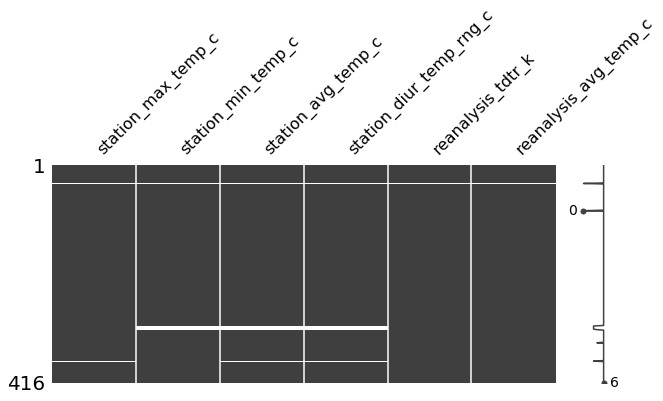

In [31]:
msno.matrix(df_test[cols_temperature], figsize=(10,4));

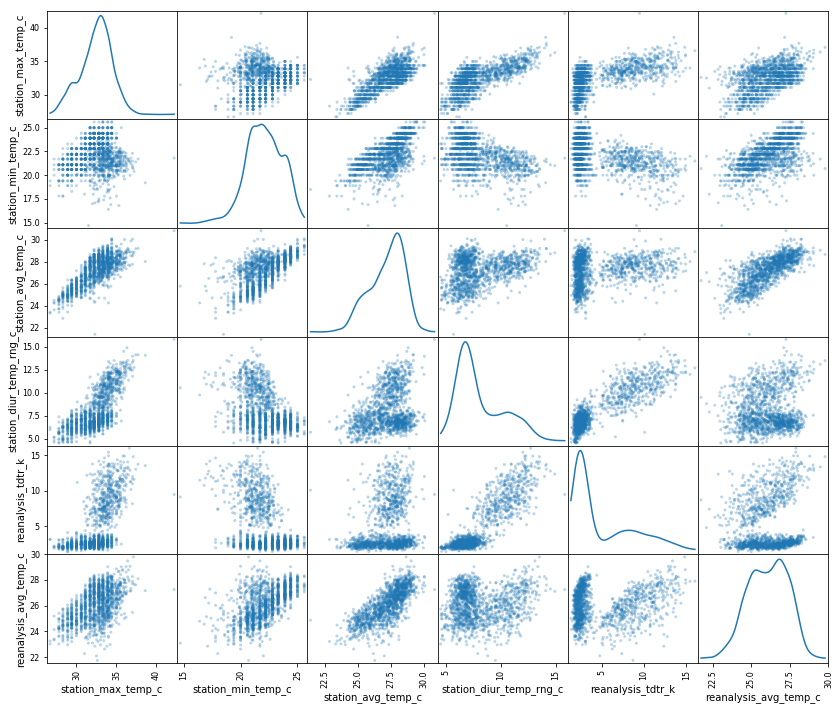

In [32]:
pd.plotting.scatter_matrix(df_train[cols_temperature], alpha = 0.3, figsize = (14,12), diagonal = 'kde');

It's notable that there is a high linear correlation between the **station_avg_temp_c** and **reanalysis_avg_temp_c**. Also, the **station_avg_temp_c** contains some missing values. So, it is *safe* to use the **reanalysis_avg_temp_c** to fulfill the missing values from **station_avg_temp_c**. The same applies between the **station_diur_temp_rng_c** and **reanalysis_tdtr_k**.

In [33]:
df_train['station_avg_temp_c'] = df_train.apply(lambda row: 
                                               row['reanalysis_avg_temp_c'] if np.isnan(row['station_avg_temp_c'])
                                               else row['station_avg_temp_c'], axis=1)
df_train['station_diur_temp_rng_c'] = df_train.apply(lambda row: 
                                               row['reanalysis_tdtr_k'] if np.isnan(row['station_diur_temp_rng_c'])
                                               else row['station_diur_temp_rng_c'], axis=1)
df_test['station_avg_temp_c'] = df_test.apply(lambda row: 
                                               row['reanalysis_avg_temp_c'] if np.isnan(row['station_avg_temp_c'])
                                               else row['station_avg_temp_c'], axis=1)
df_test['station_diur_temp_rng_c'] = df_test.apply(lambda row: 
                                               row['reanalysis_tdtr_k'] if np.isnan(row['station_diur_temp_rng_c'])
                                               else row['station_diur_temp_rng_c'], axis=1)

> For now, we do not fulfill the min and max temperature feature with missing values

#### The other features

Let's check now how the dataset is after those fulfilling and creating features.

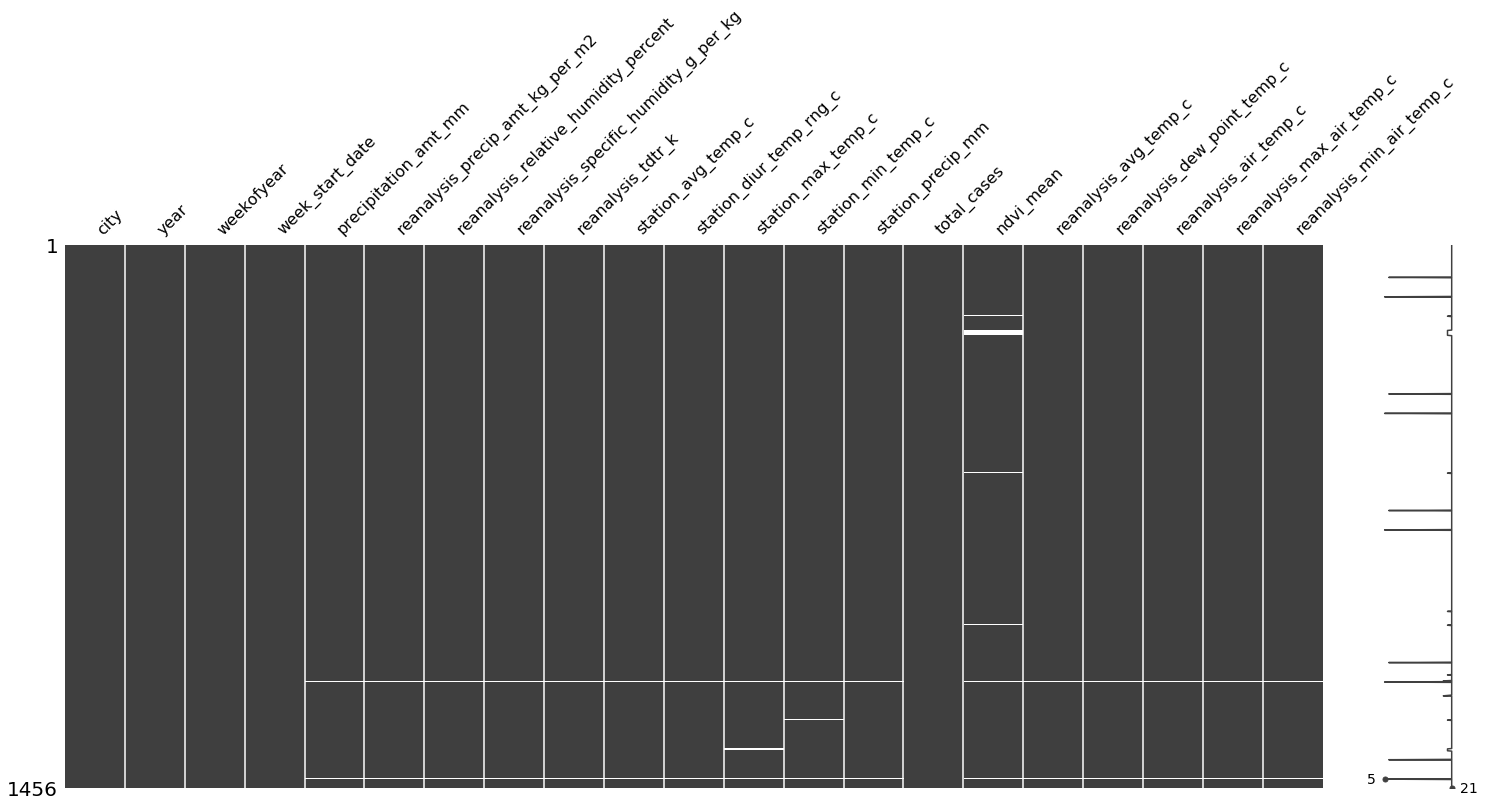

In [34]:
msno.matrix(df_train);

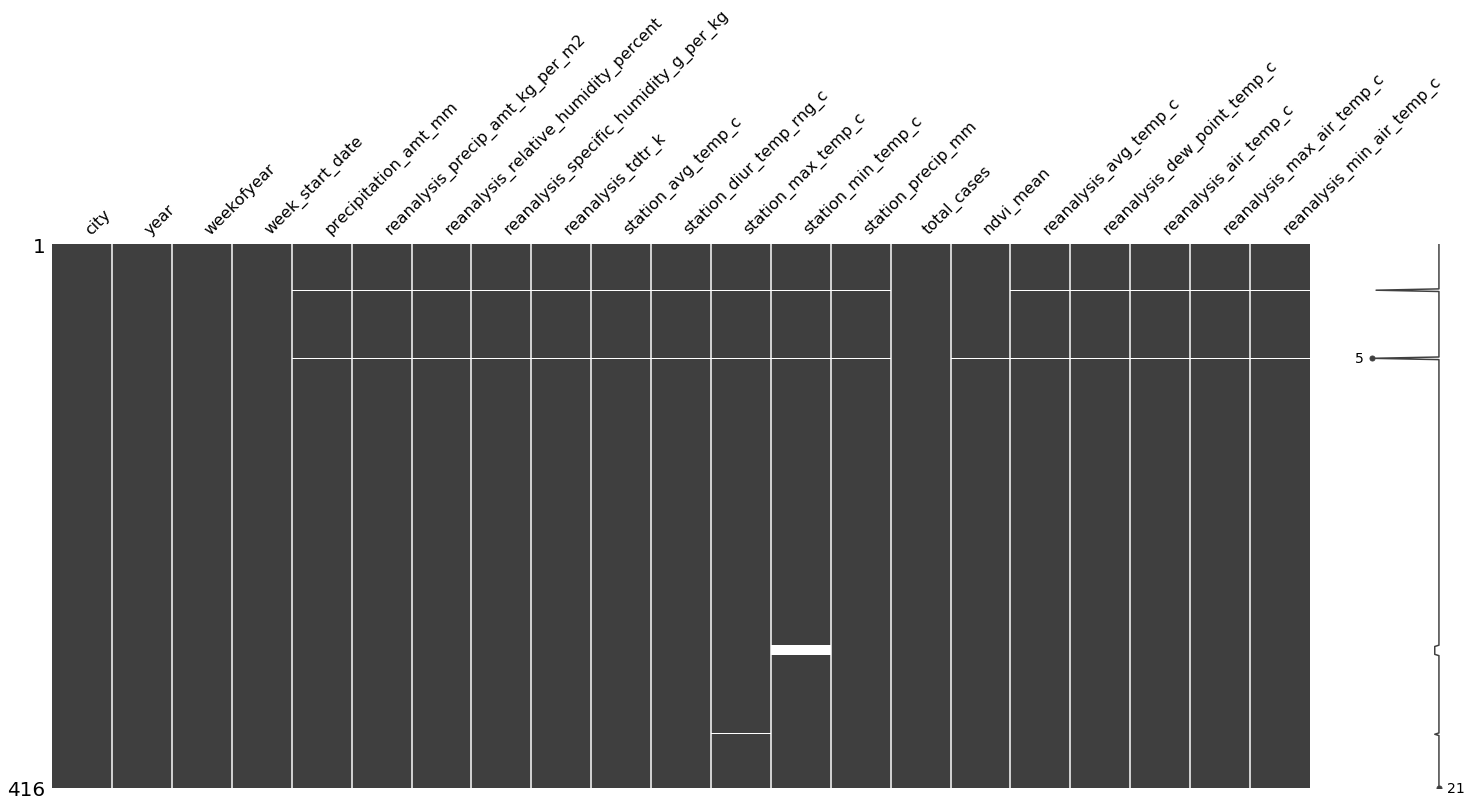

In [35]:
msno.matrix(df_test);

We can see that we still have some features to fulfill. Those columns are *harder* to work with because they don't have dependency with others. However, we have a dataset with an advantage: a **time line**.

With this powerful resource, we can **interpolate** the missing values, to remove NaN values.

#### Interpolating missing values

Before starting the interpolation, we have to remember: there are two different cities. That means, there are two different *timelines*. So, to interpolate values, we should first split the dataset in two.

In [36]:
#Creating week_start_date as index
df_train['week_start_date'] = pd.to_datetime(df_train['week_start_date'], format='%Y-%m-%d')
df_train.set_index('week_start_date', inplace=True)
#sorting index
df_train.sort_index(inplace=True)

df_test['week_start_date'] = pd.to_datetime(df_test['week_start_date'], format='%Y-%m-%d')
df_test.set_index('week_start_date', inplace=True)
df_test.sort_index(inplace=True)

In [37]:
#Checking the cities values
df_train.city.unique()

array(['sj', 'iq'], dtype=object)

In [38]:
df_train_sj = df_train[df_train['city'] == 'sj']
df_train_iq = df_train[df_train['city'] == 'iq']
#Dropping city column
df_train_sj = df_train_sj.drop(['city'], axis=1)
df_train_iq = df_train_iq.drop(['city'], axis=1)

df_test_sj = df_test[df_test['city'] == 'sj']
df_test_iq = df_test[df_test['city'] == 'iq']
#Dropping city column
df_test_sj = df_test_sj.drop(['city'], axis=1)
df_test_iq = df_test_iq.drop(['city'], axis=1)

To interpolate values to fulfill NaN, we use interpolate() from pandas. First, we have to index and sort the dataset, using the **week_start_date** feature.

To be more clear, look at a previous known missing value and their neighbors in the **sj** dataframe.

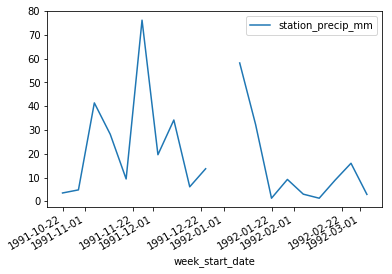

In [39]:
df_train_sj[['station_precip_mm']].iloc[77:97].plot();

There is a missing value in this example. With the interpolating method, we can find a value between all missing values from this dataset.

In [40]:
df_train_sj_inter = df_train_sj.interpolate()
df_train_iq_inter = df_train_iq.interpolate()

df_test_sj_inter = df_test_sj.interpolate()
df_test_iq_inter = df_test_iq.interpolate()

With the new dataframe, with interpolated values, it is possible to check the fulfilled values.

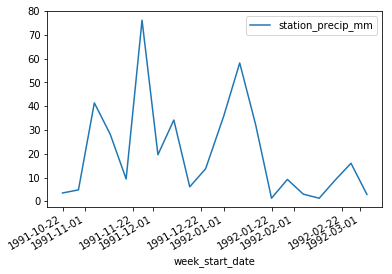

In [41]:
df_train_sj_inter[['station_precip_mm']].iloc[77:97].plot();

So, all missing values are fulfilled, without lose much information.

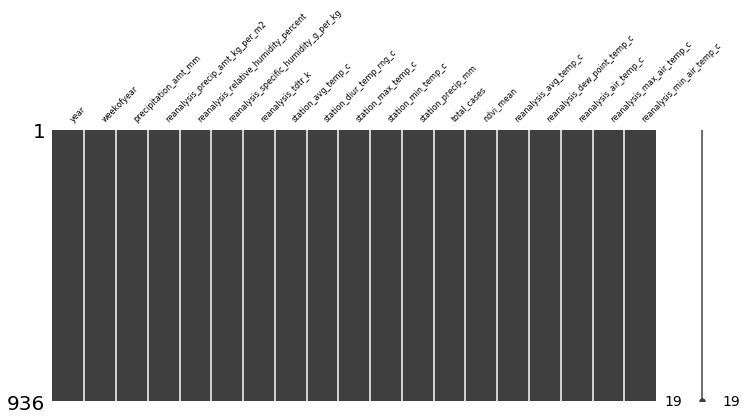

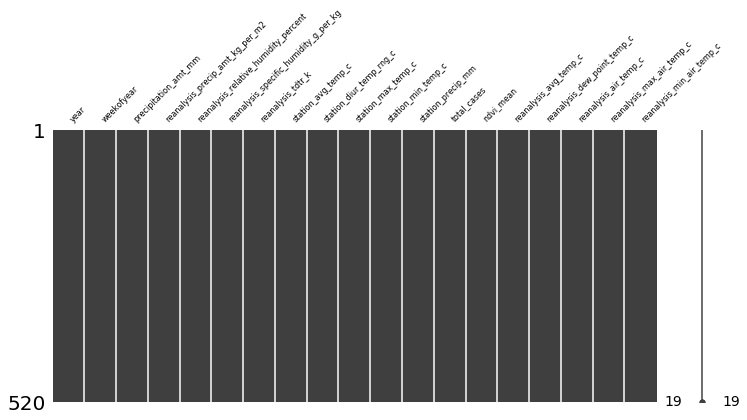

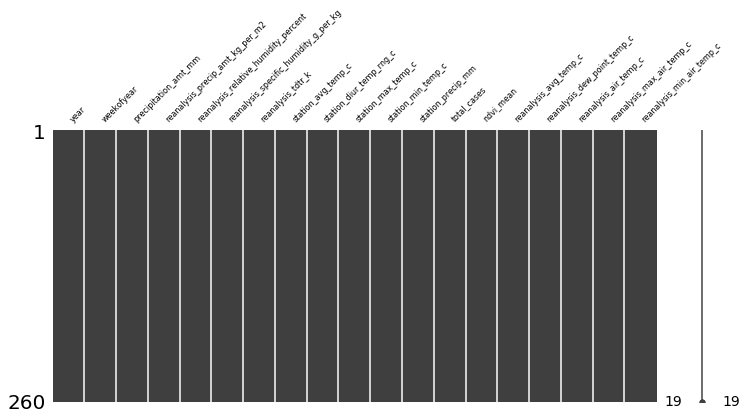

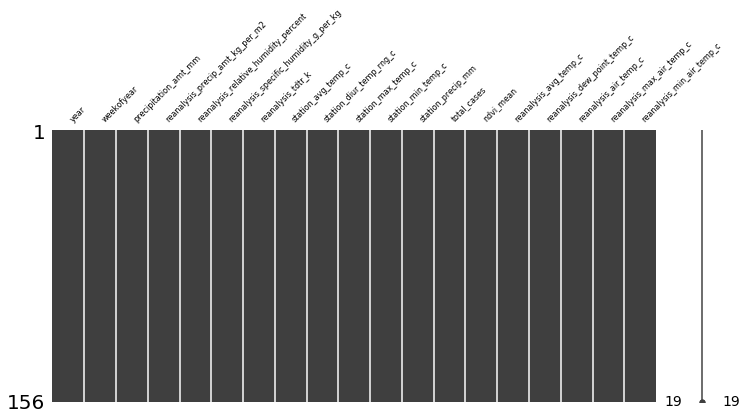

In [42]:
msno.matrix(df_train_sj_inter, figsize=(12, 5), fontsize=8)
msno.matrix(df_train_iq_inter, figsize=(12, 5), fontsize=8);

msno.matrix(df_test_sj_inter, figsize=(12, 5), fontsize=8)
msno.matrix(df_test_iq_inter, figsize=(12, 5), fontsize=8);

### Treating date/season related features <a name="fe_treating_date"></a>

The dataset contains some date/season related columns. The **week_start_date** was transformed into the index in the previous interpolation step. It will also be useful for the posterior Time Series.

Two features remain to be considered: **weekofyear** and **year**. By themselves, they seem redundant. However, **weekofyear** has a *cyclical behavior* and can be useful to represent seasonality. This feature will be transformed into its *sin* and *cosine* forms to describe a cycle [[9]](http://blog.davidkaleko.com/feature-engineering-cyclical-features.html). After that, the original column and **year** will be dropped.

In [43]:
#Creating sin/cos
df_train_sj_inter['week_sin'] = np.sin((df_train_sj_inter.weekofyear-1)*(2.*np.pi/53))
df_train_sj_inter['week_cos'] = np.cos((df_train_sj_inter.weekofyear-1)*(2.*np.pi/53))
df_train_iq_inter['week_sin'] = np.sin((df_train_iq_inter.weekofyear-1)*(2.*np.pi/53))
df_train_iq_inter['week_cos'] = np.cos((df_train_iq_inter.weekofyear-1)*(2.*np.pi/53))

df_test_sj_inter['week_sin'] = np.sin((df_test_sj_inter.weekofyear-1)*(2.*np.pi/53))
df_test_sj_inter['week_cos'] = np.cos((df_test_sj_inter.weekofyear-1)*(2.*np.pi/53))
df_test_iq_inter['week_sin'] = np.sin((df_test_iq_inter.weekofyear-1)*(2.*np.pi/53))
df_test_iq_inter['week_cos'] = np.cos((df_test_iq_inter.weekofyear-1)*(2.*np.pi/53))
#Dropping weekofyear
df_train_sj_inter = df_train_sj_inter.drop(['weekofyear'], axis=1)
df_train_iq_inter = df_train_iq_inter.drop(['weekofyear'], axis=1)
df_test_sj_inter = df_test_sj_inter.drop(['weekofyear'], axis=1)
df_test_iq_inter = df_test_iq_inter.drop(['weekofyear'], axis=1)

In [44]:
#Dropping year
df_train_sj_inter = df_train_sj_inter.drop(['year'], axis=1)
df_train_iq_inter = df_train_iq_inter.drop(['year'], axis=1)
df_test_sj_inter = df_test_sj_inter.drop(['year'], axis=1)
df_test_iq_inter = df_test_iq_inter.drop(['year'], axis=1)

### Lagging features <a name="fe_lagging_features"></a>

With the previous information about the timing between **mosquitoes bites** and **symptoms**, it's inferable that a one-week dataset may not be enough to predict the total number of cases.

The reason for that is simple: since the symptoms appear only **4-7 days after the bitting**, and we have a one-week series, the best case scenario is the bitting occurring at the beginning of the week and reported at the end of the week.

Lagging the features will provide us to use the previous week information to enhance the current week's data.

In [45]:
def lag_columns(df, columns, lag=1):
    for col in columns:
        df['lag_' + str(lag) + '_' + col] = df[col].shift(lag)
    return df

In [46]:
cols = df_train_sj_inter.columns.tolist()
cols.remove('total_cases')

Before lagging, we should check if the test dataset is a continuity of the train one.

In [47]:
df_train_sj_inter.tail(1)

,precipitation_amt_mm,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,ndvi_mean,reanalysis_avg_temp_c,reanalysis_dew_point_temp_c,reanalysis_air_temp_c,reanalysis_max_air_temp_c,reanalysis_min_air_temp_c,week_sin,week_cos
week_start_date,,,,,,,,,,,,,,,,,,,
2008-04-22,0.0,2.17,76.96,15.671429,3.957143,27.042857,7.514286,31.7,23.3,0.3,5,0.030133,25.542857,21.13,25.522857,27.75,22.75,0.947326,-0.32027


In [48]:
df_test_sj_inter.head(1)

,precipitation_amt_mm,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,ndvi_mean,reanalysis_avg_temp_c,reanalysis_dew_point_temp_c,reanalysis_air_temp_c,reanalysis_max_air_temp_c,reanalysis_min_air_temp_c,week_sin,week_cos
week_start_date,,,,,,,,,,,,,,,,,,,
2008-04-29,78.6,25.37,78.781429,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2,0,0.039032,25.4,21.377143,25.342857,27.95,23.25,0.902798,-0.430065


The test dataset begins one week after the train dataset. With that, we can use the last train dataset row to lag the first row of the test dataset.

In [49]:
#We add the last row of the Train dataset to the test dataset
df_test_sj_inter = df_test_sj_inter.append(df_train_sj_inter.tail(1), ignore_index=False).sort_index()
df_test_iq_inter = df_test_iq_inter.append(df_train_iq_inter.tail(1), ignore_index=False).sort_index()

In [50]:
# 1-week lag - Train Dataset
df_train_sj_inter = lag_columns(df_train_sj_inter, cols, lag=1)
df_train_iq_inter = lag_columns(df_train_iq_inter, cols, lag=1)

In [51]:
# 1-week lag - Validation Dataset
df_test_sj_inter = lag_columns(df_test_sj_inter, cols, lag=1)
df_test_iq_inter = lag_columns(df_test_iq_inter, cols, lag=1)

In [52]:
df_train_sj_inter.head(3)

,precipitation_amt_mm,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,...,lag_1_station_min_temp_c,lag_1_station_precip_mm,lag_1_ndvi_mean,lag_1_reanalysis_avg_temp_c,lag_1_reanalysis_dew_point_temp_c,lag_1_reanalysis_air_temp_c,lag_1_reanalysis_max_air_temp_c,lag_1_reanalysis_min_air_temp_c,lag_1_week_sin,lag_1_week_cos
week_start_date,,,,,,,,,,,,,,,,,,,,,
1990-04-30,12.42,32.00,73.365714,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-05-07,22.82,17.94,77.368571,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,...,20.0,16.0,0.150606,24.592857,19.264286,24.422857,26.65,22.75,0.902798,-0.430065
1990-05-14,34.54,26.10,82.052857,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,...,22.2,8.6,0.157479,25.292857,20.801429,25.061429,27.75,23.25,0.845596,-0.533823


In [53]:
df_test_sj_inter.head(3)

,precipitation_amt_mm,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,...,lag_1_station_min_temp_c,lag_1_station_precip_mm,lag_1_ndvi_mean,lag_1_reanalysis_avg_temp_c,lag_1_reanalysis_dew_point_temp_c,lag_1_reanalysis_air_temp_c,lag_1_reanalysis_max_air_temp_c,lag_1_reanalysis_min_air_temp_c,lag_1_week_sin,lag_1_week_cos
week_start_date,,,,,,,,,,,,,,,,,,,,,
2008-04-22,0.00,2.17,76.960000,15.671429,3.957143,27.042857,7.514286,31.7,23.3,0.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-04-29,78.60,25.37,78.781429,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2,...,23.3,0.3,0.030133,25.542857,21.130000,25.522857,27.75,22.75,0.947326,-0.320270
2008-05-06,12.56,21.83,78.230000,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3,...,21.7,75.2,0.039032,25.400000,21.377143,25.342857,27.95,23.25,0.902798,-0.430065


Notice that the first row of the lagged Dataframes contains *NaN* values in the lagged features. This behaviour is expected since the first row doesn't have the previous row.

It's worth *removing* those rows. In the train dataset we can afford to lose one row of information to build the model, and in the test dataset, we won't lose data, since the first row was originally from the train dataset.

In [54]:
df_train_sj_inter.dropna(inplace=True)
df_train_iq_inter.dropna(inplace=True)

df_test_sj_inter.dropna(inplace=True)
df_test_iq_inter.dropna(inplace=True)

In [55]:
df_train_sj_inter.head(3)

,precipitation_amt_mm,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,...,lag_1_station_min_temp_c,lag_1_station_precip_mm,lag_1_ndvi_mean,lag_1_reanalysis_avg_temp_c,lag_1_reanalysis_dew_point_temp_c,lag_1_reanalysis_air_temp_c,lag_1_reanalysis_max_air_temp_c,lag_1_reanalysis_min_air_temp_c,lag_1_week_sin,lag_1_week_cos
week_start_date,,,,,,,,,,,,,,,,,,,,,
1990-05-07,22.82,17.94,77.368571,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,...,20.0,16.0,0.150606,24.592857,19.264286,24.422857,26.65,22.75,0.902798,-0.430065
1990-05-14,34.54,26.10,82.052857,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,...,22.2,8.6,0.157479,25.292857,20.801429,25.061429,27.75,23.25,0.845596,-0.533823
1990-05-21,15.36,13.90,80.337143,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,...,22.8,41.4,0.133315,25.728571,22.284286,25.631429,27.35,24.15,0.776524,-0.630088


### Feature selection

Since the interpolation step, the dataset was separated into two, representing the two cities: **sj** and **iq**. With that, it is possible to evaluate the prediction and select relevant features for each case. The goal is to find the **total_cases** variable. So it is a *Regression problem*.

After running some previous tests and comparing some Machine Learning algorithms for regression (Random Forest, Linear Regression, Gradient Boost, SVR), the chosen one is the eXtreme Gradient Boost (XGBoost) [[11]](https://www.analyticsvidhya.com/blog/2018/09/an-end-to-end-guide-to-understand-the-math-behind-xgboost/) due to its versatility and excellent performance in this particular problem

In [56]:
import xgboost as xgb

The target **total_case** is an Integer number. We have to limit the predictions to give only integer numbers higher than 0.

In [57]:
#Round predictions and thresh to 0 and positives
def correct_prediction(pred):
    arr = np.round(pred).astype(int)
    arr[arr < 0] = 0
    return arr

Now we run and evaluate the XGBoost model using three different split in the dataset (train%/test%): **80%/20%, 70%/30%, 60%/40%**. 

Also, we use **Mean Absolute Error (MAE)** to measure the prediction, since it is the metric asked for the Driven Data challenge. We calculate then the **Mean MAE** resulted by those three splits.

The tests for each city will run separately.

In [58]:
def reg_predict(reg, X_train, y_train, X_test):
    reg.fit(X_train, y_train)
    predicted = reg.predict(X_test)
    return correct_prediction(predicted)

In [59]:
def evaluate_model(reg, X, y, r_state):
    X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(X, y, test_size=0.2, random_state=r_state)
    X_train_70, X_test_30, y_train_70, y_test_30 = train_test_split(X, y, test_size=0.3, random_state=r_state)
    X_train_60, X_test_40, y_train_60, y_test_40 = train_test_split(X, y, test_size=0.4, random_state=r_state)

    reg_20 = reg_predict(reg, X_train_80, y_train_80, X_test_20)
    reg_30 = reg_predict(reg, X_train_70, y_train_70, X_test_30)
    reg_40 = reg_predict(reg, X_train_60, y_train_60, X_test_40)

    reg_mean_mae = (mean_absolute_error(reg_20, y_test_20) + mean_absolute_error(reg_30, y_test_30) + mean_absolute_error(reg_40, y_test_40))/3
    return reg_mean_mae

In [60]:
%%time
X = df_train_sj_inter.drop(['total_cases'], axis=1)
y = df_train_sj_inter[['total_cases']]

xg_sj_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1, 
                          max_depth = 5, alpha = 10, n_estimators = 5) #Innitialy, some arbitrary parameters

print('sj 1st training (MAE): ' + str(evaluate_model(xg_sj_reg,X,y,63)) + '\n')

sj 1st training (MAE): 21.462646139012055

CPU times: user 27.3 ms, sys: 4 ms, total: 31.3 ms
Wall time: 31.1 ms


In [61]:
%%time
X = df_train_iq_inter.drop(['total_cases'], axis=1)
y = df_train_iq_inter[['total_cases']]

xg_iq_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1, 
                          max_depth = 5, alpha = 10, n_estimators = 5) #Innitialy, some arbitrary parameters

print('iq 1st training (MAE): ' + str(evaluate_model(xg_iq_reg,X,y,63)) + '\n')

iq 1st training (MAE): 6.354166666666667

CPU times: user 29.5 ms, sys: 2.29 ms, total: 31.8 ms
Wall time: 34.6 ms


The initial model performances values will serve as a comparison for the **feature selection** step.

Now we apply the Recursive Feature Selection with Cross Validation in the whole dataset, trying to find the optimal number of features with the XGBRegressor.

In [62]:
from sklearn.feature_selection import RFECV

In [63]:
def plot_optimal_rfecv(rfecv):
    print("Optimal number of features : %d" % rfecv.n_features_)
    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()

In [64]:
#Optimize the Cross Validation step using a Range between 2 and cv
def RFECV_optimized(reg, X, y, cv=5, step=1, scoring='neg_mean_absolute_error'):
    optimal_regression = 999999
    optimal_number_features = 0
    optimal_features = []
    optimal_rfecv = None
    for i in range(2, cv+1):
        rfecv = RFECV(estimator=reg, step=step, cv=i, scoring=scoring)
        rfecv.fit(X, y.values.ravel())
        if min(rfecv.grid_scores_*-1) < optimal_regression:
            optimal_regression = min(rfecv.grid_scores_*-1)
            optimal_number_features = rfecv.n_features_
            optimal_features = [f for f,s in zip(X.columns, rfecv.support_) if s]
            optimal_rfecv = rfecv
    plot_optimal_rfecv(optimal_rfecv)
    return optimal_features

Optimal number of features : 36


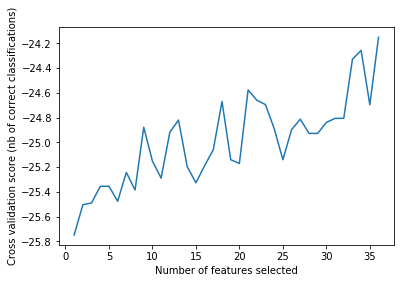

CPU times: user 1min 20s, sys: 145 ms, total: 1min 20s
Wall time: 1min 20s


In [65]:
%%time
X = df_train_sj_inter.drop(['total_cases'], axis=1)
y = df_train_sj_inter[['total_cases']]

optimal_sj_features = RFECV_optimized(xg_sj_reg, X, y, cv=30, step=1, scoring='neg_mean_absolute_error')

Optimal number of features : 31


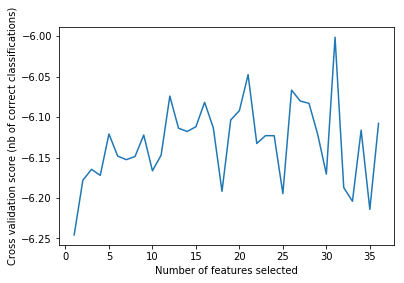

CPU times: user 57.3 s, sys: 71.3 ms, total: 57.4 s
Wall time: 57.3 s


In [66]:
%%time
X = df_train_iq_inter.drop(['total_cases'], axis=1)
y = df_train_iq_inter[['total_cases']]

optimal_iq_features = RFECV_optimized(xg_iq_reg, X, y, cv=30, step=1, scoring='neg_mean_absolute_error')

With the optimal number of features - and the best features - we can test the XGBRegressor again.

In [67]:
%%time
X = df_train_sj_inter[optimal_sj_features]
y = df_train_sj_inter[['total_cases']]

print('sj 2nd training - RFECV (MAE): ' + str(evaluate_model(xg_sj_reg,X,y,63)) + '\n')

sj 2nd training - RFECV (MAE): 21.462646139012055

CPU times: user 62.1 ms, sys: 7 ms, total: 69.1 ms
Wall time: 34.7 ms


In [68]:
%%time
X = df_train_iq_inter[optimal_iq_features]
y = df_train_iq_inter[['total_cases']]

print('iq 2nd training - RFECV (MAE): ' + str(evaluate_model(xg_iq_reg,X,y,63)) + '\n')

iq 2nd training - RFECV (MAE): 6.29647435897436

CPU times: user 34.1 ms, sys: 2.26 ms, total: 36.4 ms
Wall time: 36.6 ms


The results from the first predictor were **improved** using the feature reduction.

## Model evaluation  <a name="model_evaluation"></a>

Now, we tune the XGBoost using **Grid Search** and find some optimal parameters.

In [69]:
def reg_grid_search(reg, X, y, params, cv, scoring):
    grid = GridSearchCV(reg, params, cv=cv, iid=False, scoring=scoring)
    grid.fit(X,y)
    best_parameters = grid.best_estimator_.get_params()
    return best_parameters

In [70]:
# A parameter grid for XGBoost
params = {'objective':['reg:linear'],
          'min_child_weight':[4,5,6,7], 
          'gamma':[i/10.0 for i in range(0,5)],
          'subsample':[i/10.0 for i in range(6,11)], 
          'colsample_bytree':[i/10.0 for i in range(3,7)], 
          'learning_rate':[i/10.0 for i in range(1,5)], 
          'max_depth': [3,4,5,6,7], 
          'n_estimators': [5]}

In [71]:
%%time
X = df_train_sj_inter[optimal_sj_features]
y = df_train_sj_inter[['total_cases']]

best_parameters = reg_grid_search(xgb.XGBRegressor(nthread=-1), X, y, params, 3, 'neg_mean_absolute_error')
optm_sj_xg_reg = xgb.XGBRegressor(**best_parameters)

print('sj 3rd training - RFECV - Grid Search (MAE): ' + str(evaluate_model(optm_sj_xg_reg,X,y,63)) + '\n')

sj 3rd training - RFECV - Grid Search (MAE): 19.42612328011114

CPU times: user 4min 9s, sys: 2.02 s, total: 4min 11s
Wall time: 4min 15s


In [72]:
%%time
X = df_train_iq_inter[optimal_iq_features]
y = df_train_iq_inter[['total_cases']]

best_parameters = reg_grid_search(xgb.XGBRegressor(nthread=-1), X, y, params, 3, 'neg_mean_absolute_error')
optm_iq_xg_reg = xgb.XGBRegressor(**best_parameters)

print('iq 3rd training - RFECV - Grid Search (MAE): ' + str(evaluate_model(optm_iq_xg_reg,X,y,63)) + '\n')

iq 3rd training - RFECV - Grid Search (MAE): 6.186431623931624

CPU times: user 2min 58s, sys: 1.37 s, total: 2min 59s
Wall time: 3min 3s


At this time, we have already did the following steps:
- **Treating missing values**
- **Treating date/season related feature**
- **Feature selection**
- **Model evaluation**

## Predicting the test dataset <a name="predicting_test"></a>

Everything is set to predict the test dataset using the trained XGBRegressor model.

In [73]:
#Dataset to train optimal model
X_train_sj = df_train_sj_inter[optimal_sj_features]
y_train_sj = df_train_sj_inter[['total_cases']]
X_train_iq = df_train_iq_inter[optimal_iq_features]
y_train_iq = df_train_iq_inter[['total_cases']]
#Dataset to be predicted
X_test_sj = df_test_sj_inter[optimal_sj_features]
X_test_iq = df_test_iq_inter[optimal_iq_features]

In [74]:
#Train model
optm_sj_xg_reg.fit(X_train_sj, y_train_sj)
optm_iq_xg_reg.fit(X_train_iq, y_train_iq)
#Predict
predicted_sj = correct_prediction(optm_sj_xg_reg.predict(X_test_sj))
predicted_iq = correct_prediction(optm_iq_xg_reg.predict(X_test_iq))

With the predictions, we should update the original **df_test** DataFrame, since it contains both cities.

In [75]:
pd.options.mode.chained_assignment = None

X_test_sj['total_cases'] = predicted_sj
X_test_iq['total_cases'] = predicted_iq

X_test_sj['city'] = 'sj'
X_test_iq['city'] = 'iq'

In [76]:
df_test = df_test.reset_index().set_index(['city','week_start_date'])
df_test.update(X_test_sj.reset_index().set_index(['city','week_start_date']))
df_test.update(X_test_iq.reset_index().set_index(['city','week_start_date']))
df_test.reset_index(inplace=True)

In [77]:
#Updating the total_cases type to int again
df_test.total_cases = df_test.total_cases.astype(int)

#### Preparing the submission

For the DrivenData challenge, it's necessary to submit a *csv* file with the predictions. We can use the **df_test** to update the submission format file.

In [78]:
df_submission = pd.read_csv('data/submission_format.csv')
df_submission.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,0
1,sj,2008,19,0
2,sj,2008,20,0
3,sj,2008,21,0
4,sj,2008,22,0


In [79]:
df_submission = df_submission.set_index(['city','year','weekofyear'])
df_submission.update(df_test.set_index(['city','year','weekofyear']))
df_submission.reset_index(inplace=True)
df_submission.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,9
1,sj,2008,19,9
2,sj,2008,20,9
3,sj,2008,21,9
4,sj,2008,22,9


In [80]:
#Creating the sumission file
df_submission.to_csv('data/submission.csv', index=False)

## Discussion <a name="discussion"></a>

In order to make the model's performance more clear, following will be the comparison between the **observed** (real values), **validation** (results from the model on the training data) and **predicted** (results from prediction of the testing data).

In [110]:
#Validation line
validate_sj = correct_prediction(optm_sj_xg_reg.predict(X_train_sj))
sj_validation = df_train_sj_inter[['total_cases']].copy()
sj_validation['total_cases'] = validate_sj

validate_iq = correct_prediction(optm_iq_xg_reg.predict(X_train_iq))
iq_validation = df_train_iq_inter[['total_cases']].copy()
iq_validation['total_cases'] = validate_iq

In [144]:
#Calculating the MAE using the validation
sj_mae = mean_absolute_error(y_train_sj['total_cases'].values, validate_sj)
iq_mae = mean_absolute_error(y_train_iq['total_cases'].values, validate_iq)

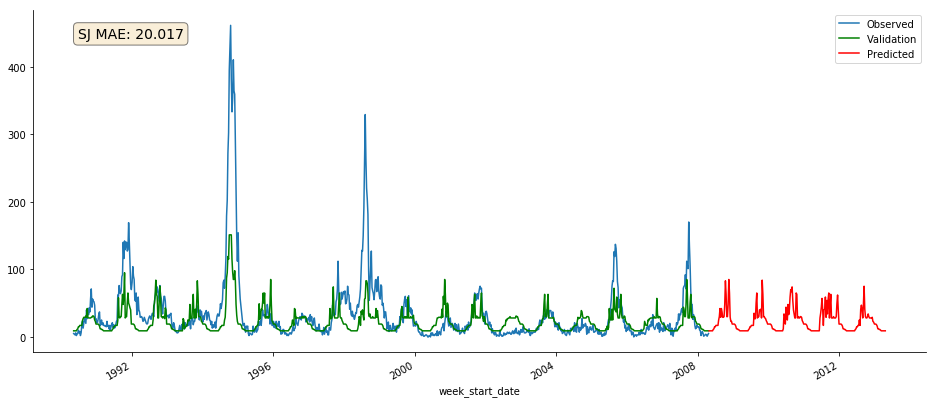

In [145]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
textstr = 'SJ MAE: ' + str(round(sj_mae, 3))
ax = y_train_sj.plot(label='SJ - Observed', figsize=(16, 7))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
sj_validation[['total_cases']].plot(ax=ax, label='Validation', color='green')
X_test_sj[['total_cases']].plot(ax=ax, label='Predicted', color='red')
ax.legend(['Observed', 'Validation', 'Predicted'])
plt.show()

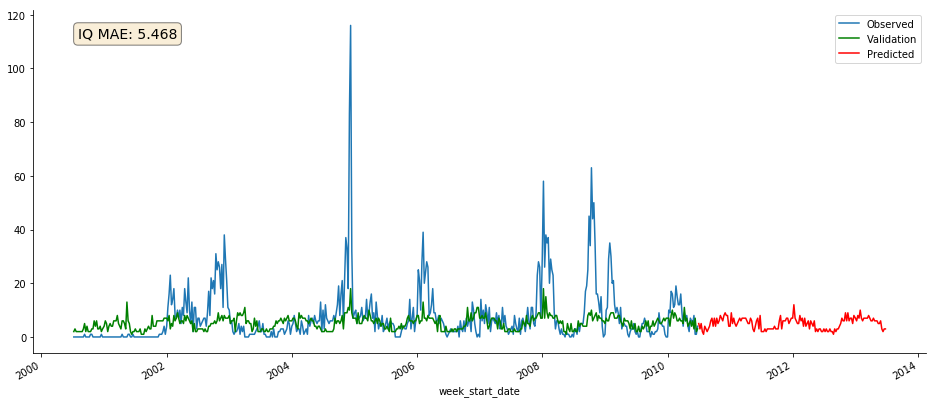

In [146]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
textstr = 'IQ MAE: ' + str(round(iq_mae, 3))
ax = y_train_iq.plot(label='IQ - Observed', figsize=(16, 7))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
iq_validation[['total_cases']].plot(ax=ax, label='Validation', color='green')
X_test_iq[['total_cases']].plot(ax=ax, label='Predicted', color='red')
ax.legend(['Observed', 'Validation', 'Predicted'])
plt.show()

It is visible that the **IQ** city is more predictable, due to a lower *Mean Absolute Error*. Another reason for that is the values range. **SJ** has more total cases per week, and it is more visible at the *peaks*. That means *any* bad predicted value can penalty more the results on the **SJ** city.

### Future work

Some suggestion for improving this work:
- Using LSTM to predict the disease as a time series
- Weight the peaks of values in the model to reduce the mean absolute error